In [2]:
import os
import re
import time
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap
import hdbscan

import os
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/casoriano/ .cache'

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-bakmodio because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Abstract Preprocessing

In [3]:
df = pd.read_excel('research_profile_v1.xlsx').drop([112, 167, 638, 648, 663, 787, 1138, 1204])
docs = df['Abstract'].copy().dropna()#.reset_index(drop=True)

length = docs.str.split(' ').apply(lambda x: np.log(len(x)))
docs = docs[abs((length - length.mean())/length.std()) < 3]
docs = docs.apply(lambda x: re.sub(r'[^a-zA-Z0-9- ]', '', x)).str.lower()

docs.head()

0    the ched phernet-admu program has been conduct...
1    the warm tropical climate of the philippines a...
2    the study was conducted to determine the green...
3    this study aimed to establish a solid waste ma...
4    farming systems refers to the utilization of t...
Name: Abstract, dtype: object

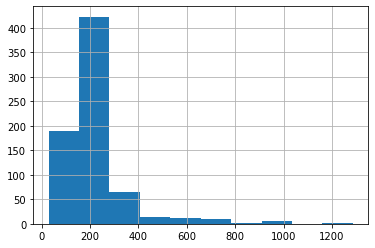

In [4]:
docs.str.split(' ').apply(lambda x: len(x)).hist();

### Document Embeddings

In [4]:
model = SentenceTransformer('allenai/specter')
model.max_seq_length = 512

In [5]:
start = time.time()
embeddings = model.encode(docs.tolist(), convert_to_tensor=True)
print("Time for computing embeddings:", time.time()-start)
embeddings = pd.DataFrame(embeddings.cpu().numpy())
embeddings

Time for computing embeddings: 10.194308757781982


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.367278,0.446500,0.319726,-0.698154,-0.476773,-0.158669,0.073073,0.268992,0.352473,1.087897,...,0.481664,0.107410,0.987301,0.914397,-0.070303,-0.735920,-0.051531,0.494734,0.646963,0.570346
1,-0.108545,0.612939,0.535368,0.213604,-0.435395,-0.058225,-0.800363,-0.199306,-0.348939,0.962904,...,0.102022,0.129303,1.033372,0.853780,-0.167301,-0.255200,-0.078423,0.402345,0.437901,0.298196
2,-0.997458,0.409005,0.277808,-0.478699,-0.532011,-0.521333,0.056212,0.015039,-0.094822,0.660898,...,0.051799,-0.030300,1.008335,0.727391,-0.524004,-0.384851,-0.019957,0.748829,0.636491,0.336037
3,-0.694803,0.594741,0.447962,-0.234862,-0.869753,-0.118493,-0.410902,0.525824,-0.032186,0.721736,...,0.158341,0.616047,0.780993,0.547096,-0.478923,-0.328133,-0.000795,0.666931,0.693948,-0.108173
4,-0.391576,0.501825,-0.570256,-0.291601,-1.244321,0.483091,-1.043804,0.007342,-0.057918,0.771143,...,0.374886,0.085463,0.565957,1.276083,-0.558830,-0.327890,0.278374,0.046977,0.196731,-0.150847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,-0.420018,0.370974,-0.387536,-0.528355,-1.042832,0.039290,-1.220826,-0.368853,0.217233,1.266508,...,0.686647,0.260706,0.370555,1.263869,-0.510141,-0.506912,0.325203,-0.019186,0.100607,-0.408220
712,-0.662184,0.715052,0.405479,-0.351547,-1.267767,-0.050714,0.018628,0.217659,0.212043,0.881130,...,0.722220,-0.059985,0.686017,1.004132,0.004198,0.155933,0.335847,0.614836,0.318907,-0.101132
713,-0.792260,0.289158,0.525411,-0.082245,-1.051845,0.108599,-0.893857,0.590328,0.182516,0.861393,...,1.061466,0.434379,0.549747,0.941730,-0.249641,-0.932843,-0.297525,0.348355,0.502012,-0.426852
714,-0.581676,0.217078,0.027812,-0.576196,-0.823438,0.043948,-0.611694,-0.462973,0.161373,0.620844,...,0.776629,-0.140010,0.562174,1.047250,-0.310835,-0.397593,-0.049942,-0.332041,0.489083,0.204366


### Clustering

#### kmeans

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

inertias = []
ci_scores = []
silh_scores = []
db_scores = []
for k in range(2, 21):
    clusterer = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    labels = clusterer.labels_
    inertias.append(clusterer.inertia_)
    ci_scores.append(calinski_harabasz_score(embeddings, labels))
    silh_scores.append(silhouette_score(embeddings, labels, metric='cosine'))
    db_scores.append(davies_bouldin_score(embeddings, labels))

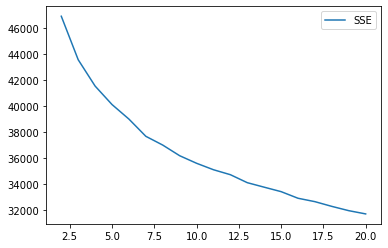

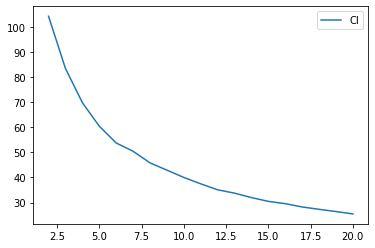

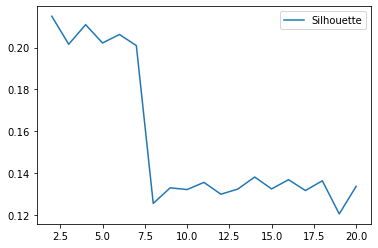

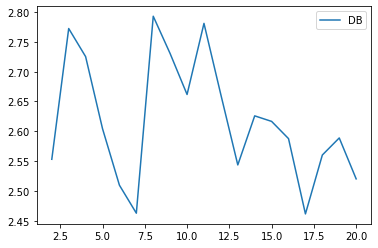

In [8]:
plt.plot(range(2, 21), inertias, label='SSE')
plt.legend()
plt.show()
plt.plot(range(2, 21), ci_scores, label='CI')
plt.legend()
plt.show()
plt.plot(range(2, 21), silh_scores, label='Silhouette')
plt.legend()
plt.show()
plt.plot(range(2, 21), db_scores, label='DB')
plt.legend()
plt.show()

In [10]:
clusterer = KMeans(n_clusters=7, random_state=42).fit(embeddings)
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

#### DBSCAN

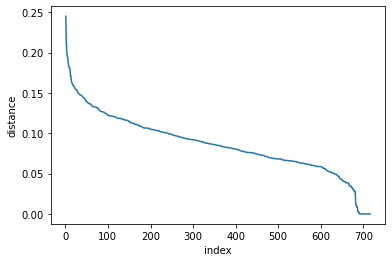

In [10]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, metric='cosine').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

dist_desc = sorted(distances[:,-1], reverse=True)
plt.plot(list(range(1,len(dist_desc)+1)), dist_desc)
plt.xlabel("index")
plt.ylabel("distance")
plt.show()

In [14]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.150, min_samples=2, metric='cosine', n_jobs=-1).fit(embeddings)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

Estimated number of clusters: 12
Estimated number of noise points: 30
CI Coefficient: 4.33707
Silhouette Coefficient: 0.01235
DB Coefficient: 2.24356


#### Agglomerative Clustering - Complete

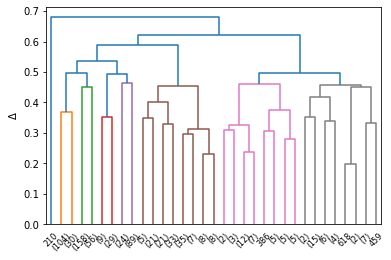

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_tree(Z, ylabel='$\Delta$'):
    fig, ax = plt.subplots()
    dn = dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_ylabel(f'{ylabel}')

Z = linkage(embeddings, method='complete', metric='cosine', optimal_ordering=True)
plot_tree(Z)
# plt.axhline(0.33, color='red')
plt.show()

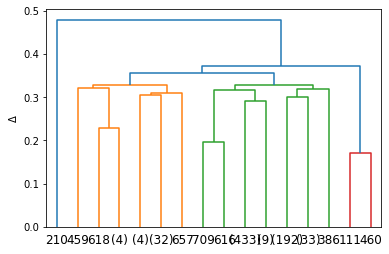

In [15]:
Z = linkage(embeddings, method='average', metric='cosine', optimal_ordering=True)
plot_tree(Z)

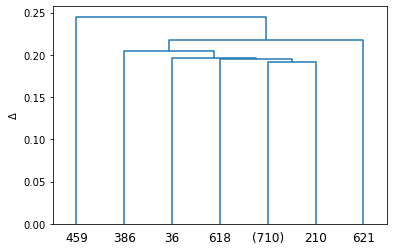

In [16]:
Z = linkage(embeddings, method='single', metric='cosine', optimal_ordering=True)
plot_tree(Z)

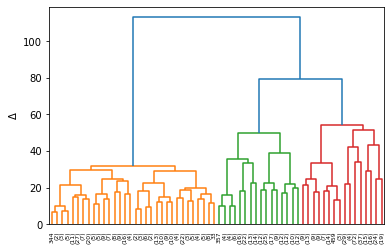

In [17]:
Z = linkage(embeddings, method='ward', metric='euclidean', optimal_ordering=True)
plot_tree(Z)

In [18]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

Z = linkage(embeddings, method='complete', metric='cosine', optimal_ordering=True)
labels = fcluster(Z, t=0.33, criterion='distance')

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

Estimated number of clusters: 37
Estimated number of noise points: 0
CI Coefficient: 14.82755
Silhouette Coefficient: 0.06216
DB Coefficient: 2.16020


#### Spectral Co-Clustering

In [19]:
from sklearn.cluster import SpectralCoclustering

scoring = ['run_time', 'CI Coefficient', 'Silhouette Coefficient', 'DB Coefficient']
results = pd.DataFrame(columns=scoring)
for i in range(2, 21):
    start_time = time.time()
    scc = SpectralCoclustering(n_clusters=i, svd_method='arpack', random_state=42).fit(embeddings)
    labels = scc.row_labels_
    results.loc[i] = {"run_time": time.time() - start_time,
                                    'CI Coefficient': calinski_harabasz_score(embeddings, labels),
                                    'Silhouette Coefficient': silhouette_score(embeddings, labels),
                                    'DB Coefficient': davies_bouldin_score(embeddings, labels)}
results

,run_time,CI Coefficient,Silhouette Coefficient,DB Coefficient
2,0.138648,1.733169,0.002805,19.784811
3,0.424296,78.330525,0.104145,3.092773
4,0.450614,57.419522,0.073447,4.023137
5,0.479636,54.777649,0.049462,3.591812
6,0.500303,46.019446,0.033587,4.004596
7,0.587949,41.132257,0.032704,3.985253
8,0.469463,38.278080,0.035412,4.147631
9,0.572665,37.648581,0.048141,3.436047
10,0.612122,34.607004,0.043296,3.374239
11,0.539433,32.625823,0.038315,3.404174


<AxesSubplot:>

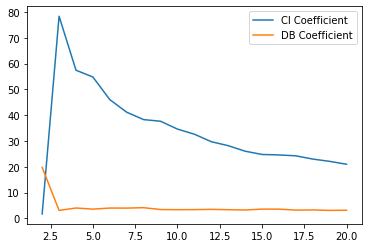

In [20]:
results[['CI Coefficient', 'DB Coefficient']].plot()

#### HDBSCAN w/o UMAP

In [9]:
from sklearn.metrics.pairwise import cosine_distances

cos_dist = cosine_distances(embeddings).astype('double')

clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                          min_samples=2,
                          metric='precomputed').fit(cos_dist)
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("CI Coefficient: %0.5f"
      % calinski_harabasz_score(embeddings, labels))
print("Silhouette Coefficient: %0.5f"
      % silhouette_score(embeddings, labels))
print("DB Coefficient: %0.5f"
      % davies_bouldin_score(embeddings, labels))

Estimated number of clusters: 2
Estimated number of noise points: 72
CI Coefficient: 12.44814
Silhouette Coefficient: 0.05840
DB Coefficient: 3.59198


#### HDBSCAN with UMAP

In [15]:
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

In [22]:
temp = umap.UMAP(n_neighbors=20, n_components=2, metric='cosine').fit_transform(embeddings)

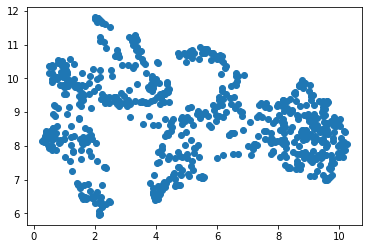

In [23]:
result = pd.DataFrame(temp, columns=['x', 'y'])

plt.scatter(result.x, result.y);

In [26]:
results = []

for i in range(2, 21):
    for j in range(2, 21):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=i,
                                    min_samples=j,
                                    metric='euclidean').fit(umap_embeddings)
        labels = clusterer.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        results.append([i, j, n_clusters_, n_noise_,
                        calinski_harabasz_score(umap_embeddings, labels),
                        silhouette_score(umap_embeddings, labels),
                        davies_bouldin_score(umap_embeddings, labels)])

In [32]:
temp = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'clusters',
                                      'noise', 'CI', 'Silh', 'DB'])
temp[(temp['clusters'] < 20) & (temp['clusters'] > 6)].sort_values(['noise', 'CI', 'Silh', 'DB'], ascending=[True, False, False, True]).head(20)

,min_cluster_size,min_samples,clusters,noise,CI,Silh,DB
190,12,2,10,25,567.458040,0.369350,1.258355
209,13,2,10,25,567.458040,0.369350,1.258355
228,14,2,10,25,567.458040,0.369350,1.258355
247,15,2,10,25,567.458040,0.369350,1.258355
171,11,2,11,36,527.241029,0.359497,1.251552
343,20,3,11,61,587.534709,0.418539,1.514613
305,18,3,12,61,566.798726,0.409749,1.453678
324,19,3,12,61,566.798726,0.409749,1.453678
267,16,3,13,61,548.094340,0.420760,1.415748
286,17,3,13,61,548.094340,0.420760,1.415748


### c-TFIDF

In [81]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15,
                            min_samples=2,
                            metric='euclidean').fit(umap_embeddings)
labels = clusterer.labels_

In [95]:
docs_df = pd.DataFrame(docs.tolist(), columns=["Doc"])
docs_df['Topic'] = labels
docs_df['index'] = docs.index
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [85]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 6)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs.tolist()))

In [86]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes['Names'] = ['EDUCATION', 'CROP CULTIVATION', 'DATA SCIENCE / COMPUTER VISION',
                        'GOVERNANCE / POLICY', 'INDIGENOUS PEOPLE / TRADITION AND HISTORY', 'PANDEMIC',
                        'Outliers', 'UTILITIES / TRANSPORTATION', 'LIVESTOCK AGRICULTURE', 'MARINE BIOLOGY',
                        'BIODIVERSITY / CONSERVATIONISM']
topic_sizes

,Topic,Size,Names
2,1,239,EDUCATION
6,5,203,CROP CULTIVATION
7,6,51,DATA SCIENCE / COMPUTER VISION
9,8,48,GOVERNANCE / POLICY
10,9,39,INDIGENOUS PEOPLE / TRADITION AND HISTORY
1,0,37,PANDEMIC
0,-1,25,Outliers
8,7,21,UTILITIES / TRANSPORTATION
5,4,20,LIVESTOCK AGRICULTURE
4,3,18,MARINE BIOLOGY


In [112]:
docs_df['Topic Name'] = docs_df['Topic'].map(topic_sizes[['Topic', 'Names']].set_index('Topic').to_dict()['Names'])
docs_df.set_index('index').to_csv('abstract_topic.csv')

In [46]:
print('EDUCATION')
top_n_words[1]

EDUCATION


[('teachers', 0.0013559298432959303),
 ('teaching', 0.0012913610188605249),
 ('school', 0.0012517247918847716),
 ('skills', 0.001220519176672448),
 ('education', 0.001204781812679556),
 ('academic', 0.001129836782827765),
 ('learning', 0.0011285940329325975),
 ('teacher', 0.0011067824243076816),
 ('respondents', 0.001052147943344061),
 ('mathematics', 0.0010358107666016939),
 ('student', 0.0010065063567759973),
 ('faculty', 0.000922682235347681),
 ('state', 0.0009125306281367547),
 ('online', 0.0008950012819248826),
 ('college', 0.0008901818283336151),
 ('graduates', 0.0008641252551327857),
 ('performance', 0.0008366068011360188),
 ('level', 0.0008310468997841143),
 ('science', 0.0008282695370881235),
 ('self', 0.0008253017261968584)]

In [70]:
print('CROP CULTIVATION')
top_n_words[5]

CROP CULTIVATION


[('rice', 0.0013302956437845996),
 ('farmers', 0.001210975748329163),
 ('water', 0.0011884250192959408),
 ('yield', 0.0011350522455385787),
 ('food', 0.001013040624510212),
 ('growth', 0.0008352629503625336),
 ('soil', 0.0008284461116480899),
 ('production', 0.0008138342632938394),
 ('varieties', 0.0008074583209051551),
 ('climate', 0.0008006522952036226),
 ('plant', 0.0007849193906218359),
 ('plants', 0.0007822339409551462),
 ('fruit', 0.0007647719218038849),
 ('agricultural', 0.0007533638102204689),
 ('products', 0.0007434070428780133),
 ('banana', 0.0007386906556749264),
 ('treatments', 0.0007232340792922513),
 ('seeds', 0.000699512965044899),
 ('crops', 0.000682619073281407),
 ('drying', 0.0006769421374912896)]

In [52]:
print('DATA SCIENCE')
top_n_words[6]

DATA SCIENCE


[('algorithm', 0.0036846209799575656),
 ('model', 0.002129521553521999),
 ('image', 0.0021008363707202774),
 ('encryption', 0.002077288223168847),
 ('accuracy', 0.002019612355221529),
 ('images', 0.0018323577101344518),
 ('machine', 0.001803823763470283),
 ('delay', 0.0017753557627664313),
 ('algorithms', 0.0017753557627664313),
 ('detection', 0.0017386629933886155),
 ('proposed', 0.0015410172721207504),
 ('classifier', 0.0015408976317364072),
 ('differential', 0.0015306334275980982),
 ('feature', 0.0015306334275980982),
 ('numerical', 0.0014886033674159133),
 ('predator', 0.0014780925502657553),
 ('cancer', 0.001468803373713891),
 ('time', 0.001453105844070956),
 ('equations', 0.0014424765572477257),
 ('symmetry', 0.0013974261060491406)]

In [55]:
print('GOVERNMENT POLICY')
top_n_words[8]

GOVERNMENT POLICY


[('waste', 0.003206985456856629),
 ('financial', 0.0023872384968443234),
 ('firms', 0.0023178881428052777),
 ('waste management', 0.0019688230569695287),
 ('solid', 0.0017976210520156567),
 ('solid waste', 0.0017551186320379632),
 ('business', 0.0017516752177352182),
 ('health', 0.0017160179830361445),
 ('awareness', 0.0016992961335021248),
 ('entrepreneurial', 0.0016865809872794696),
 ('solid waste management', 0.0015451286801040683),
 ('level awareness', 0.001528537452075481),
 ('humor', 0.001497029651405172),
 ('economic', 0.0014230315097521888),
 ('suicide', 0.0014221650717175386),
 ('ic', 0.0013519875950910598),
 ('management', 0.0013404065697181153),
 ('entrepreneurs', 0.0013313277496424943),
 ('peace', 0.0012974256978844825),
 ('migration', 0.0012757645620367966)]

In [54]:
print('INDIGENOUS PEOPLE')
top_n_words[9]

INDIGENOUS PEOPLE


[('indigenous', 0.0034432849439649444),
 ('cultural', 0.0033126670833700995),
 ('culture', 0.0026345513517644376),
 ('woven', 0.002410579993660871),
 ('oral', 0.0022670611109849343),
 ('dutertes', 0.0021647407434744817),
 ('discourse', 0.0020128635062757905),
 ('identity', 0.00200395539961557),
 ('tinguian', 0.00200395539961557),
 ('philosophy', 0.001967946130431347),
 ('paper', 0.0018734077303976496),
 ('tradition', 0.0018115771556482113),
 ('regional', 0.0017358539087914044),
 ('igorot', 0.0016944205194517404),
 ('igorots', 0.001526669028952228),
 ('identities', 0.001526669028952228),
 ('designs', 0.001511374073989956),
 ('patterns', 0.0015110911621538112),
 ('philippine', 0.0014660472901388243),
 ('textual', 0.0014437621531349727)]

In [61]:
print('PANDEMIC')
top_n_words[0]

PANDEMIC


[('face', 0.005464372511452131),
 ('masks', 0.004015036369485833),
 ('shall', 0.003997029364393874),
 ('face masks', 0.0035827021855431847),
 ('distribution', 0.0034587073938559614),
 ('mask', 0.003208128207222444),
 ('alcohol', 0.002924848733447129),
 ('shields', 0.0025957305690980574),
 ('face shields', 0.0025957305690980574),
 ('face mask', 0.0024957482161927593),
 ('project', 0.0024330362272786195),
 ('office', 0.002272412652340472),
 ('fabrication', 0.002146296693800601),
 ('hospitals', 0.002146296693800601),
 ('sewing', 0.0020735825229751706),
 ('layer', 0.0020708065204782205),
 ('sanitizer', 0.001961735385789137),
 ('baguio', 0.0019523286470380975),
 ('products', 0.0018586936586534794),
 ('production', 0.0018577484025152718)]

In [63]:
print('UTILITIES / TRANSPORTATION')
top_n_words[7]

UTILITIES / TRANSPORTATION


[('energy', 0.004743004549907382),
 ('transport', 0.0039069467296666),
 ('electric', 0.0034482165457389645),
 ('power', 0.0025343241107352033),
 ('room', 0.0024979470044486658),
 ('electricity', 0.0024531224306214676),
 ('software', 0.002430676654931244),
 ('optimal', 0.0022577092740469875),
 ('arduino', 0.0021964153318885394),
 ('transportation', 0.002193805311532726),
 ('public', 0.0021816645591674257),
 ('home', 0.0020571267290749114),
 ('appliances', 0.0020423158198090183),
 ('rfid', 0.0020423158198090183),
 ('generator', 0.0020423158198090183),
 ('device', 0.0019373783053464012),
 ('desirability', 0.001916860713192325),
 ('phone', 0.0018808453885848899),
 ('transport desirability', 0.001719213360218356),
 ('tool', 0.0016378157579887036)]

In [66]:
print('LIVESTOCK AGRICULTURE')
top_n_words[4]

LIVESTOCK AGRICULTURE


[('feed', 0.00588906940888235),
 ('weight', 0.005072618159691232),
 ('egg', 0.0049409725882346225),
 ('feeding', 0.003933717480375666),
 ('pigs', 0.0037081557902282685),
 ('quails', 0.0037081557902282685),
 ('wslmd', 0.003535421589407751),
 ('abw', 0.0033586195794668263),
 ('portulaca', 0.0033586195794668263),
 ('tilapia', 0.0033586195794668263),
 ('goats', 0.0031187181809334817),
 ('cfd', 0.0030640320441533845),
 ('music', 0.002997844614007972),
 ('azolla', 0.002991603085547939),
 ('fed', 0.002991603085547939),
 ('commercial', 0.002758866638988628),
 ('blood', 0.0026886189198518508),
 ('meat', 0.0026553804190921565),
 ('diet', 0.002638915383866792),
 ('brood', 0.0026041674739141515)]

In [114]:
print('FISHERIES')
top_n_words[3]

FISHERIES


[('reef', 0.005075674643666218),
 ('marine', 0.0047928016995129625),
 ('fish', 0.004670484393408557),
 ('fishes', 0.004418080845826115),
 ('species', 0.004362681322239745),
 ('giant', 0.004022054144314482),
 ('samal', 0.0037684051139193165),
 ('coral', 0.003705489807682652),
 ('seagrass', 0.0035799518894414385),
 ('habitats', 0.00335129120211235),
 ('island', 0.0033176181111451873),
 ('fishing', 0.003066233537487793),
 ('samal island', 0.0029852234896851253),
 ('reef fishes', 0.0029852234896851253),
 ('fisheries', 0.0027676944553532193),
 ('clams', 0.002605271209137005),
 ('panay', 0.0025598297463196103),
 ('clam', 0.0025598297463196103),
 ('giant clams', 0.002391561815464601),
 ('sites', 0.0023765409571803345)]

In [69]:
print('BIODIVERSITY / CONSERVATIONISM')
top_n_words[2]

BIODIVERSITY and CONSERVATIONISM


[('species', 0.008520399683356676),
 ('diversity', 0.00582295301677518),
 ('biodiversity', 0.005620007118046507),
 ('island', 0.004285298502081108),
 ('threatened', 0.00420649228786368),
 ('conservation', 0.0037463517750657978),
 ('flora', 0.0035269109214259506),
 ('forest', 0.0034573685104337722),
 ('endemic', 0.003365193830290944),
 ('tree species', 0.0031691014784895406),
 ('new species', 0.0028902512527848845),
 ('protected', 0.002826746818423871),
 ('medicinal value', 0.00279708069985212),
 ('species diversity', 0.00279708069985212),
 ('tree', 0.0027898210385259884),
 ('medicinal', 0.0025815020090459956),
 ('cordillera', 0.0025302250125721765),
 ('habitat', 0.002523895372718208),
 ('families', 0.002522981288792846),
 ('luzon island', 0.0025003738564151026)]